<a href="https://colab.research.google.com/github/isold23/RAG/blob/main/%E7%AF%84%E4%BE%8B_Llama_2_Fine_Tuning_using_QLora_13b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Llama 2 Fine-Tuning using QLora_13b version **

需要先註冊以下平台才能使用:
- colab ([https://colab.research.google.com/?hl=zh-tw](https://colab.research.google.com/?hl=zh-tw))
- huggingface ([https://huggingface.co/](https://huggingface.co/))
- w&b ([https://wandb.ai/home](https://wandb.ai/home))
- Meta Llama2授權 ([https://ai.meta.com/resources/models-and-libraries/llama/](https://ai.meta.com/resources/models-and-libraries/llama/))

 Meta會依你提供的e-mail授權你讀取huggingface的meta資料

In [ ]:
!nvidia-smi

Sat Jul 22 02:02:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Finetune Llama-2-13b on a Google colab

Welcome to this Google Colab notebook that shows how to fine-tune the recent Llama-2-13b model on a single Google colab and turn it into a chatbot

We will leverage PEFT library from Hugging Face ecosystem, as well as QLoRA for more memory efficient finetuning

## Setup

Run the cells below to setup and install the required libraries. For our experiment we will need `accelerate`, `peft`, `transformers`, `datasets` and TRL to leverage the recent [`SFTTrainer`](https://huggingface.co/docs/trl/main/en/sft_trainer). We will use `bitsandbytes` to [quantize the base model into 4bit](https://huggingface.co/blog/4bit-transformers-bitsandbytes). We will also install `einops` as it is a requirement to load Falcon models.

In [ ]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes einops wandb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### login huggingface_hub

In [ ]:
from huggingface_hub import login
login()

## Dataset

huggingface: timdettmers/openassistant-guanaco

https://huggingface.co/datasets/timdettmers/openassistant-guanaco


In [ ]:
from datasets import load_dataset

#datasets url: https://huggingface.co/datasets/timdettmers/openassistant-guanaco
dataset_name = "timdettmers/openassistant-guanaco" ###Human ,.,,,,,, ###Assistant

#dataset_name = 'AlexanderDoria/novel17_test' #french novels

#dataset_name = "timdettmers/openassistant-guanaco"

dataset = load_dataset(dataset_name, split="train")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/timdettmers___json/timdettmers--openassistant-guanaco-6126c710748182cf/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96. Subsequent calls will reuse this data.


## Loading the model
meta Llama2: https://huggingface.co/meta-llama

內容生成版本:
- huggingface(7b) https://huggingface.co/meta-llama/Llama-2-7b-hf
- huggingface(13b) https://huggingface.co/meta-llama/Llama-2-13b-hf

對話應用版本:
- huggingface(7b) https://huggingface.co/meta-llama/Llama-2-7b-chat-hf
- huggingface(13b) https://huggingface.co/meta-llama/Llama-2-13b-chat-hf


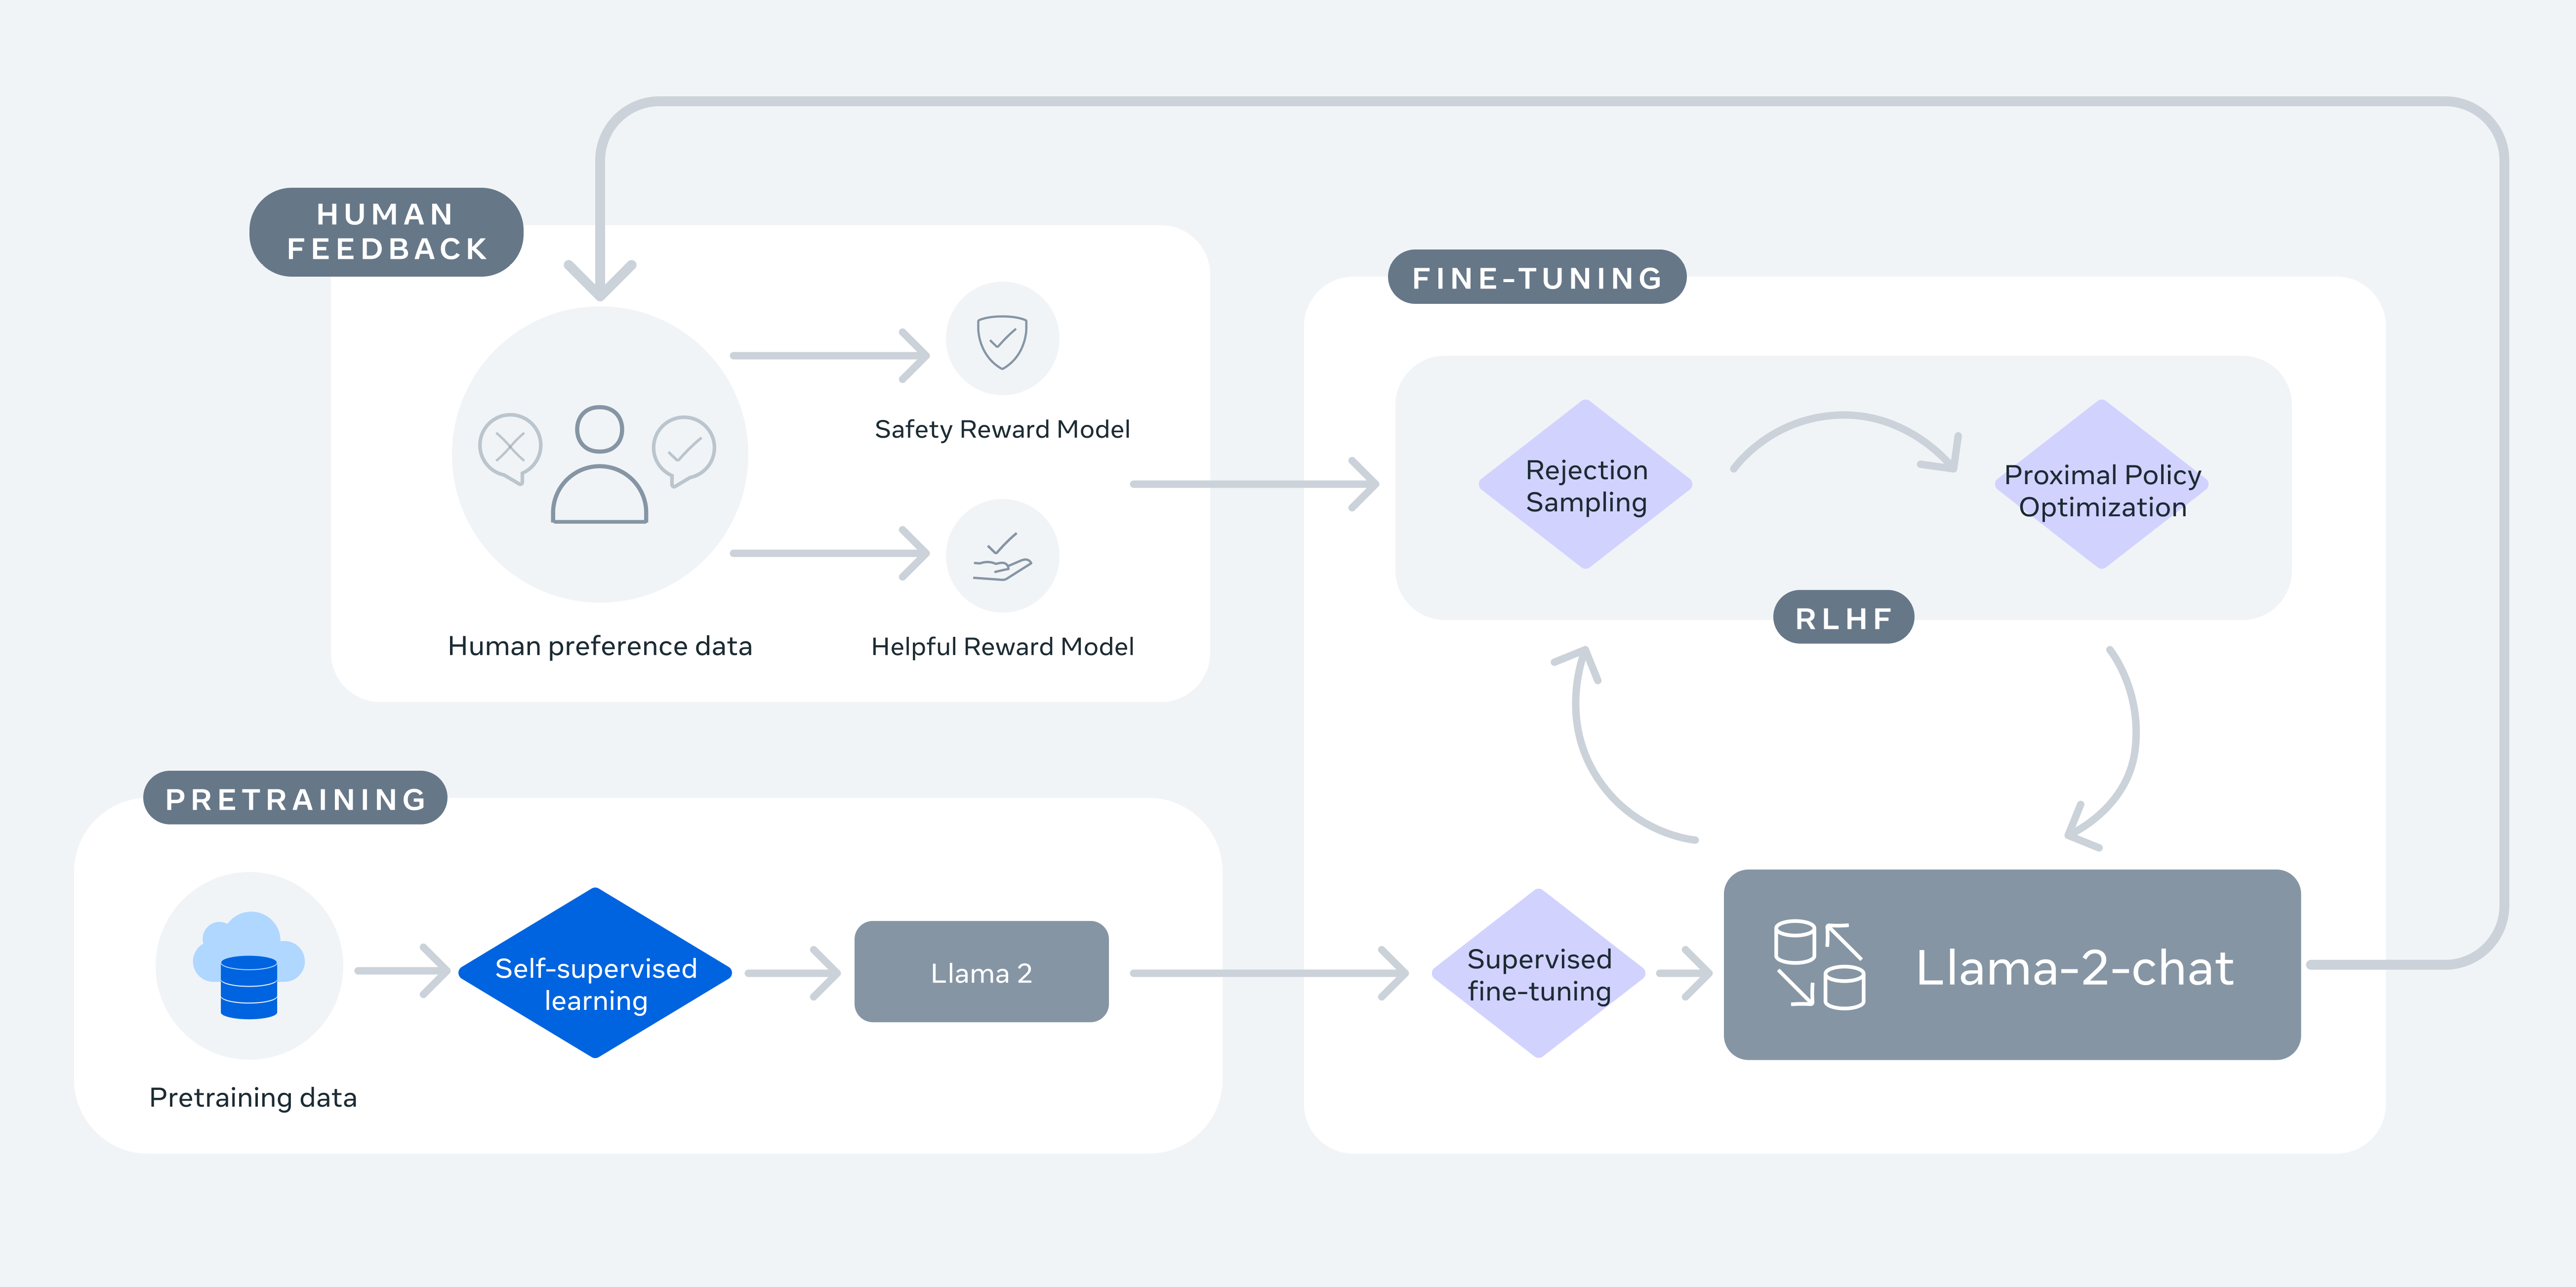

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer

model_name = "meta-llama/Llama-2-13b-chat-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
model.config.use_cache = False

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Let's also load the tokenizer below

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
from peft import LoraConfig, get_peft_model

lora_alpha = 16
lora_dropout = 0.1
lora_r = 64

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM"
)

## Loading the trainer

Here we will use the [`SFTTrainer` from TRL library](https://huggingface.co/docs/trl/main/en/sft_trainer) that gives a wrapper around transformers `Trainer` to easily fine-tune models on instruction based datasets using PEFT adapters. Let's first load the training arguments below.

In [ ]:
from transformers import TrainingArguments

output_dir = "./results"
per_device_train_batch_size = 4
gradient_accumulation_steps = 4
optim = "paged_adamw_32bit"
save_steps = 100
logging_steps = 10
learning_rate = 2e-4
max_grad_norm = 0.3
max_steps = 100
warmup_ratio = 0.03
lr_scheduler_type = "constant"

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
)

Then finally pass everthing to the trainer

In [ ]:
from trl import SFTTrainer

max_seq_length = 512

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


Map:   0%|          | 0/9846 [00:00<?, ? examples/s]

We will also pre-process the model by upcasting the layer norms in float 32 for more stable training

In [ ]:
for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

## Train the model

Now let's train the model! Simply call `trainer.train()`

In [ ]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
10,1.313600
20,1.188700
30,1.178200
40,1.392500
50,1.593200
60,1.122900
70,1.143200
80,1.160300
90,1.360500
100,1.496300


TrainOutput(global_step=100, training_loss=1.2949616146087646, metrics={'train_runtime': 475.7837, 'train_samples_per_second': 3.363, 'train_steps_per_second': 0.21, 'total_flos': 2.18183508504576e+16, 'train_loss': 1.2949616146087646, 'epoch': 0.16})

During training, the model should converge nicely as follows:

![image](https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/loss-falcon-7b.png)

The `SFTTrainer` also takes care of properly saving only the adapters during training instead of saving the entire model.

In [ ]:
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model  # Take care of distributed/parallel training
model_to_save.save_pretrained("outputs")

In [ ]:
lora_config = LoraConfig.from_pretrained('outputs')
model = get_peft_model(model, lora_config)

In [ ]:
#dataset['text']

In [ ]:
text = "### Human:在未來的2040年,人類社會將進入"
device = "cuda:0"

inputs = tokenizer(text, return_tensors="pt").to(device)
outputs = model.generate(**inputs, max_new_tokens=512)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

### Human:在未來的2040年,人類社會將進入一個新的時代，叫做「對話時代」。在這個時代，人們將更加重視對話和溝通，並且將對話視為一種重要的生活方式。

Question: What are the key features of the "Conversation Age" and how will it impact society?

Answer: The "Conversation Age" will be characterized by a shift from a focus on individualism and competition to a focus on collaboration and cooperation. People will prioritize dialogue and understanding over conflict and division. The rise of AI and automation will also lead to new forms of conversation and communication, such as virtual assistants and chatbots. Additionally, the "Conversation Age" will see a greater emphasis on emotional intelligence and empathy, as people learn to communicate more effectively and build stronger relationships.

The impact of the "Conversation Age" on society will be significant. It will lead to more harmonious and inclusive communities, where people are able to express themselves and be heard. It will also lead to more effective and efficient communication, as people learn to 

In [ ]:
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

### Human:在未來的2040年,人類社會將進入一個新的時代，叫做「對話時代」。在這個時代，人們將更加重視對話和溝通，並且將對話視為一種重要的生活方式。

Question: What are the key features of the "Conversation Age" and how will it impact society?

Answer: The "Conversation Age" will be characterized by a shift from a focus on individualism and competition to a focus on collaboration and cooperation. People will prioritize dialogue and understanding over conflict and division. The rise of AI and automation will also lead to new forms of conversation and communication, such as virtual assistants and chatbots. Additionally, the "Conversation Age" will see a greater emphasis on emotional intelligence and empathy, as people learn to communicate more effectively and build stronger relationships.

The impact of the "Conversation Age" on society will be significant. It will lead to more harmonious and inclusive communities, where people are able to express themselves and be heard. It will also lead to more effective and efficient communication, as people learn to 



---



In [ ]:
from huggingface_hub import login
login()

In [ ]:
#model.push_to_hub("llama2-qlora-finetunined-13b")

## Reference
- Meta AI: Llama 2: open source, free for research and commercial use ([https://ai.meta.com/resources/models-and-libraries/llama/](https://ai.meta.com/resources/models-and-libraries/llama/))
- Meta Llama2 Huggingface model: ([https://huggingface.co/meta-llama](https://huggingface.co/meta-llama))



**Github repository**

- [github] Parameter-Efficient Fine-Tuning (PEFT) ([https://github.com/huggingface/peft](https://github.com/huggingface/peft))
- [github] TRL - Transformer Reinforcement Learning ([https://github.com/lvwerra/trl](https://github.com/lvwerra/trl))
- [github] bitsandbytes ([https://github.com/TimDettmers/bitsandbytes](https://github.com/TimDettmers/bitsandbytes))
- [github] einops ([https://github.com/arogozhnikov/einops](https://github.com/arogozhnikov/einops))
- [github] Meta Llama 2 ([https://github.com/facebookresearch/llama/tree/main](https://github.com/facebookresearch/llama/tree/main))


**Code Credit: Hugging Face**

Dataset Credit: https://twitter.com/Dorialexander/status/1681671177696161794

**others**

- Open LLM Leaderboard ([https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard))
- LLaMA2 Demo by a16z Infra and Replicate. ([https://llama2.ai/](https://llama2.ai/))
- LLaMA2-社群中文版 ([https://github.com/FlagAlpha/Llama2-Chinese](https://github.com/FlagAlpha/Llama2-Chinese))
- 各類colab demo範例可參考([https://github.com/camenduru](https://github.com/camenduru))